In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.experimental.ode import odeint
import numpy as np
import matplotlib.pyplot as plt
import optax

from flax import linen as nn
from flax.training import train_state
from jax import random

In [2]:
import sys
import os

path_ = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if path_ not in sys.path:
    sys.path.append(path_)

from non_parametric_collocation import collocate_data
from data_generation import generate_ode_data

In [3]:
n_points = 200
noise_level = 0.2
ode_type = "harmonic_oscillator"
params = {"omega_squared": 4}
start_time=0
end_time=10
spacing_type="equally_spaced"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

spacing_type="chebyshev"
t_cheb, y_cheb, y_noisy_cheb, true_derivatives_cheb = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

In [4]:
#--------------------------------------------NON PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)
estimated_derivative_cheb, estimated_solution_cheb = collocate_data(y_noisy_cheb, t_cheb, 'EpanechnikovKernel', bandwidth=0.5)

### Noise = 0.2

Loss equal: 34.636
Loss Chebyshev: 47.221


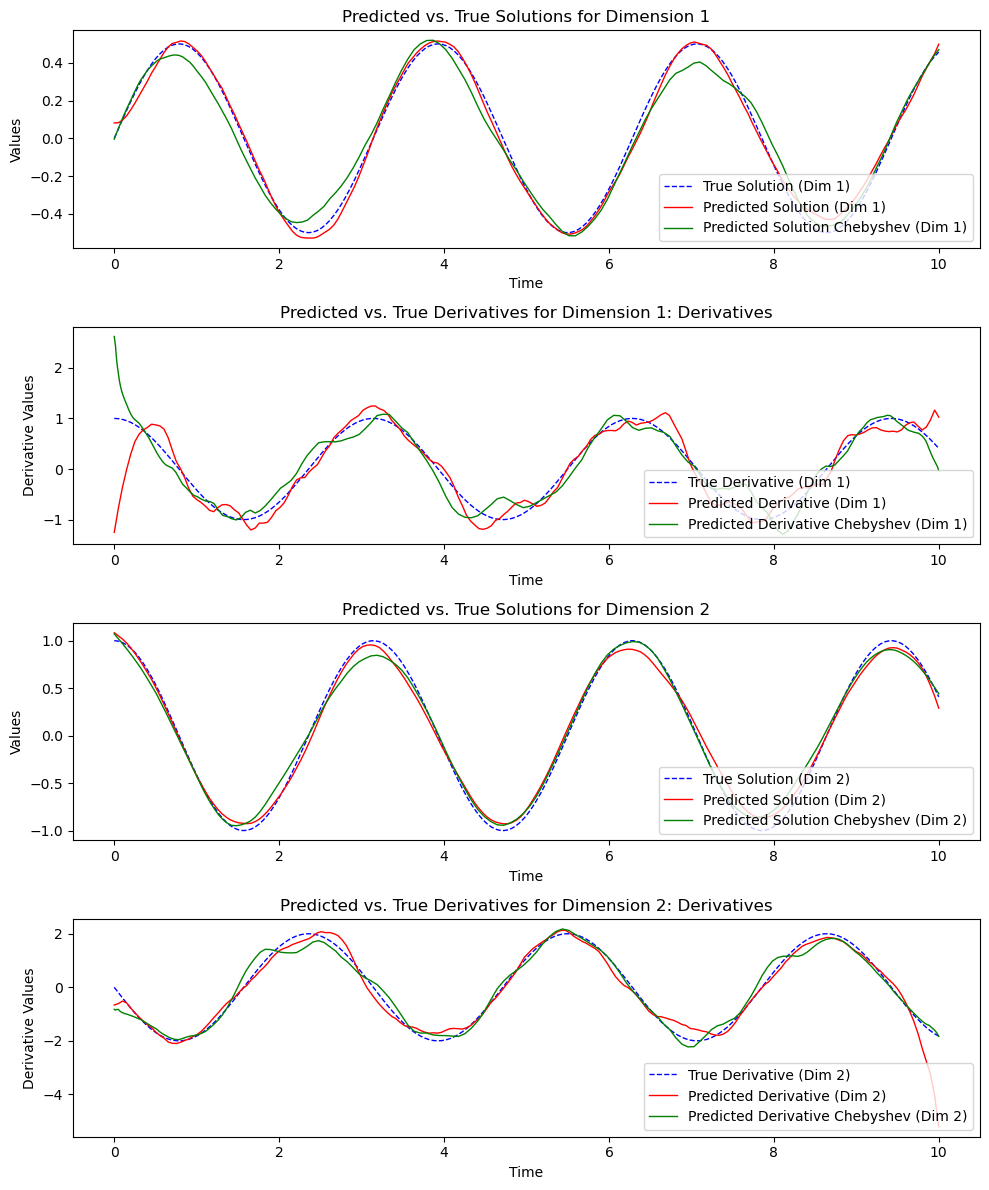

In [5]:
plt.figure(figsize=(10, 12))

# Subplot 1: Solutions
plt.subplot(4, 1, 1)  
plt.plot(t, y[:, 0], 'b--', linewidth=1, label='True Solution (Dim 1)')
plt.plot(t, estimated_solution[0], 'r-', linewidth=1, label='Predicted Solution (Dim 1)')
plt.plot(t_cheb, estimated_solution_cheb[0], 'g-', linewidth=1, label='Predicted Solution Chebyshev (Dim 1)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Predicted vs. True Solutions for Dimension 1')
plt.legend(loc='lower right')

# Subplot 2: Derivatives
plt.subplot(4, 1, 2)  
plt.plot(t, true_derivatives[:, 0], 'b--', linewidth=1, label='True Derivative (Dim 1)')
plt.plot(t, estimated_derivative[0], 'r-', linewidth=1, label='Predicted Derivative (Dim 1)')
plt.plot(t_cheb, estimated_derivative_cheb[0], 'g-', linewidth=1, label='Predicted Derivative Chebyshev (Dim 1)')
plt.xlabel('Time')
plt.ylabel('Derivative Values')
plt.title('Predicted vs. True Derivatives for Dimension 1: Derivatives')
plt.legend(loc='lower right')

plt.subplot(4, 1, 3)  
plt.plot(t, y[:, 1], 'b--', linewidth=1, label='True Solution (Dim 2)')
plt.plot(t, estimated_solution[1], 'r-', linewidth=1, label='Predicted Solution (Dim 2)')
plt.plot(t_cheb, estimated_solution_cheb[1], 'g-', linewidth=1, label='Predicted Solution Chebyshev (Dim 2)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Predicted vs. True Solutions for Dimension 2')
plt.legend(loc='lower right')

# Subplot 2: Derivatives
plt.subplot(4, 1, 4)  
plt.plot(t, true_derivatives[:, 1], 'b--', linewidth=1, label='True Derivative (Dim 2)')
plt.plot(t, estimated_derivative[1], 'r-', linewidth=1, label='Predicted Derivative (Dim 2)')
plt.plot(t_cheb, estimated_derivative_cheb[1], 'g-', linewidth=1, label='Predicted Derivative Chebyshev (Dim 2)')
plt.xlabel('Time')
plt.ylabel('Derivative Values')
plt.title('Predicted vs. True Derivatives for Dimension 2: Derivatives')
plt.legend(loc='lower right')

print(f"Loss equal: {jnp.sum(jnp.abs(true_derivatives.T[0] - estimated_derivative[0])):.3f}")
print(f"Loss Chebyshev: {jnp.sum(jnp.abs(true_derivatives_cheb.T[0] - estimated_derivative_cheb[0])):.3f}")

plt.tight_layout() 
plt.show()


In [6]:
#--------------------------------------------NON PARAMETRIC COLLOCATION--------------------------------------------#
#-----------------------------------------------VARYING NOISE LEVELS-----------------------------------------------#
results = {}

for i, noise in enumerate([0.0, 0.1, 0.2, 0.3, 0.4, 0.5]):
    t, y, y_noisy, true_derivatives = generate_ode_data(n_points, noise, ode_type, params, start_time, end_time, spacing_type, initial_state)
    
    estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)
    
    results[str(i)] = {'y_true':y, 'y_noisy': y_noisy, 't':t, 'estimated_derivative':estimated_derivative, 'estimated_solution':estimated_solution, "noise_level":noise}

Loss equal: 0.582
Loss Chebyshev: 0.236


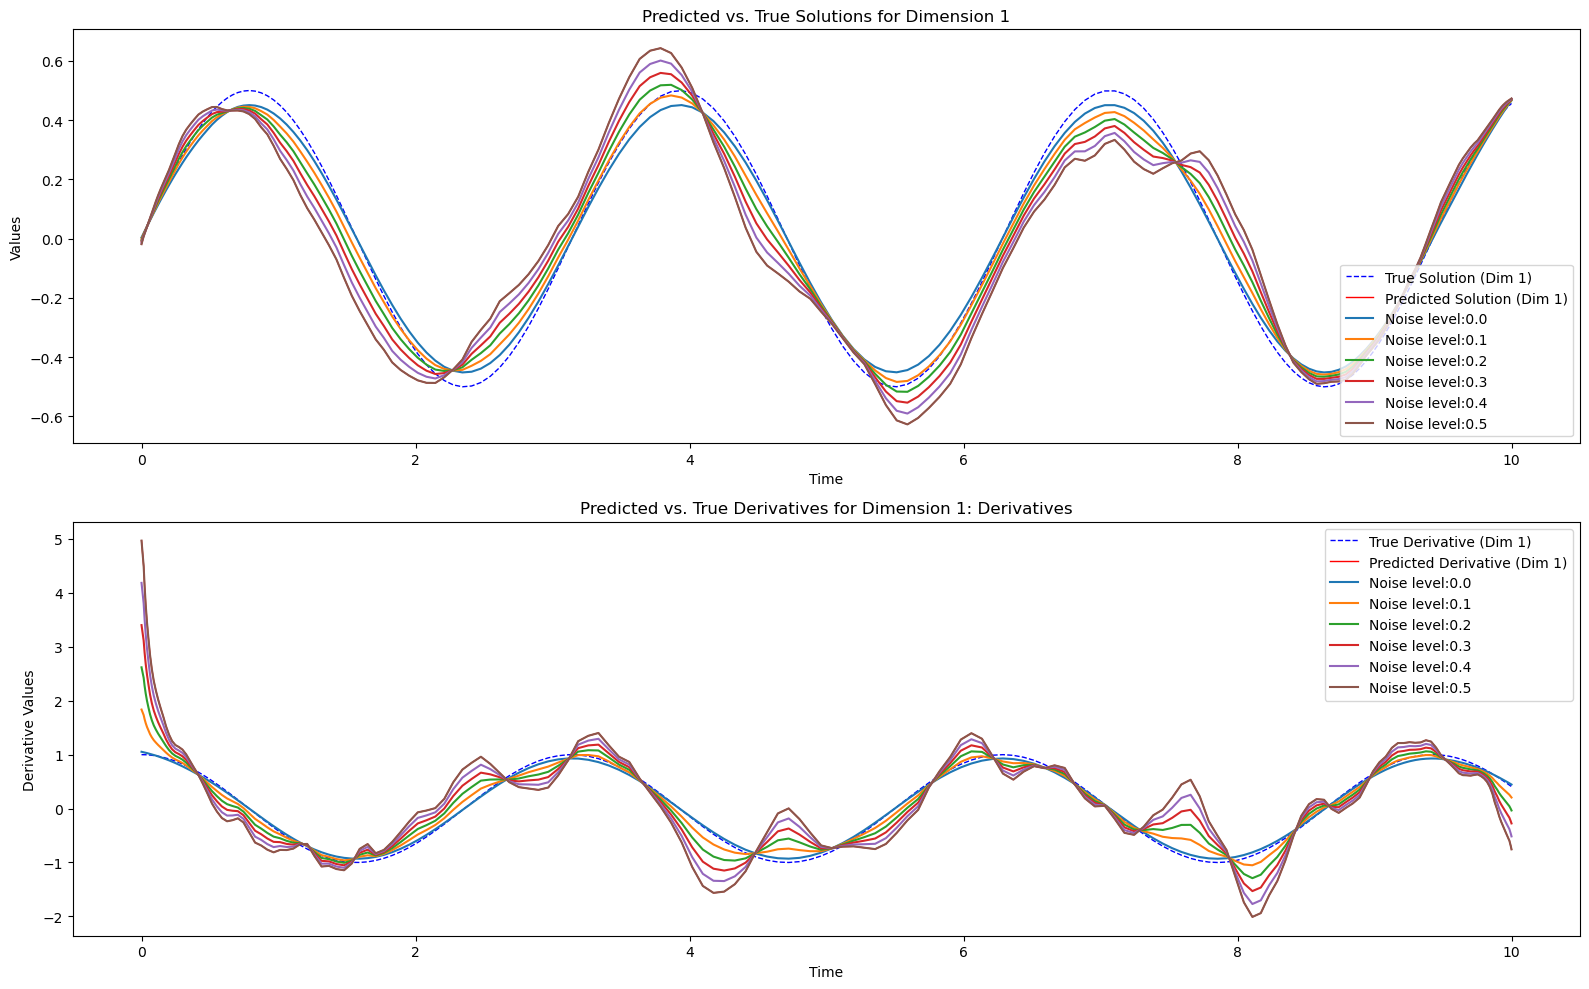

In [7]:
plt.figure(figsize=(16, 10))

# Subplot 1: Solutions
plt.subplot(2, 1, 1)  
plt.plot(t, y[:, 0], 'b--', linewidth=1, label='True Solution (Dim 1)')
plt.plot(t, estimated_solution[0], 'r-', linewidth=1, label='Predicted Solution (Dim 1)')
for i in range(len(results)):
    result = results[str(i)]
    plt.plot(t, result['estimated_solution'][0], label=f"Noise level:{result['noise_level']}")
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Predicted vs. True Solutions for Dimension 1')
plt.legend(loc='lower right')

# Subplot 2: Derivatives
plt.subplot(2, 1, 2)  
plt.plot(t, true_derivatives[:, 0], 'b--', linewidth=1, label='True Derivative (Dim 1)')
plt.plot(t, estimated_derivative[0], 'r-', linewidth=1, label='Predicted Derivative (Dim 1)')
for i in range(len(results)):
    result = results[str(i)]
    plt.plot(t, result['estimated_derivative'][0], label=f"Noise level:{result['noise_level']}")
plt.xlabel('Time')
plt.ylabel('Derivative Values')
plt.title('Predicted vs. True Derivatives for Dimension 1: Derivatives')
plt.legend(loc='upper right')

print(f"Loss equal: {jnp.mean(jnp.abs(true_derivatives.T[0] - estimated_derivative[0])):.3f}")
print(f"Loss Chebyshev: {jnp.mean(jnp.abs(true_derivatives_cheb.T[0] - estimated_derivative_cheb[0])):.3f}")

plt.tight_layout() 
plt.show()


Loss equal: 0.471
Loss Chebyshev: 0.203


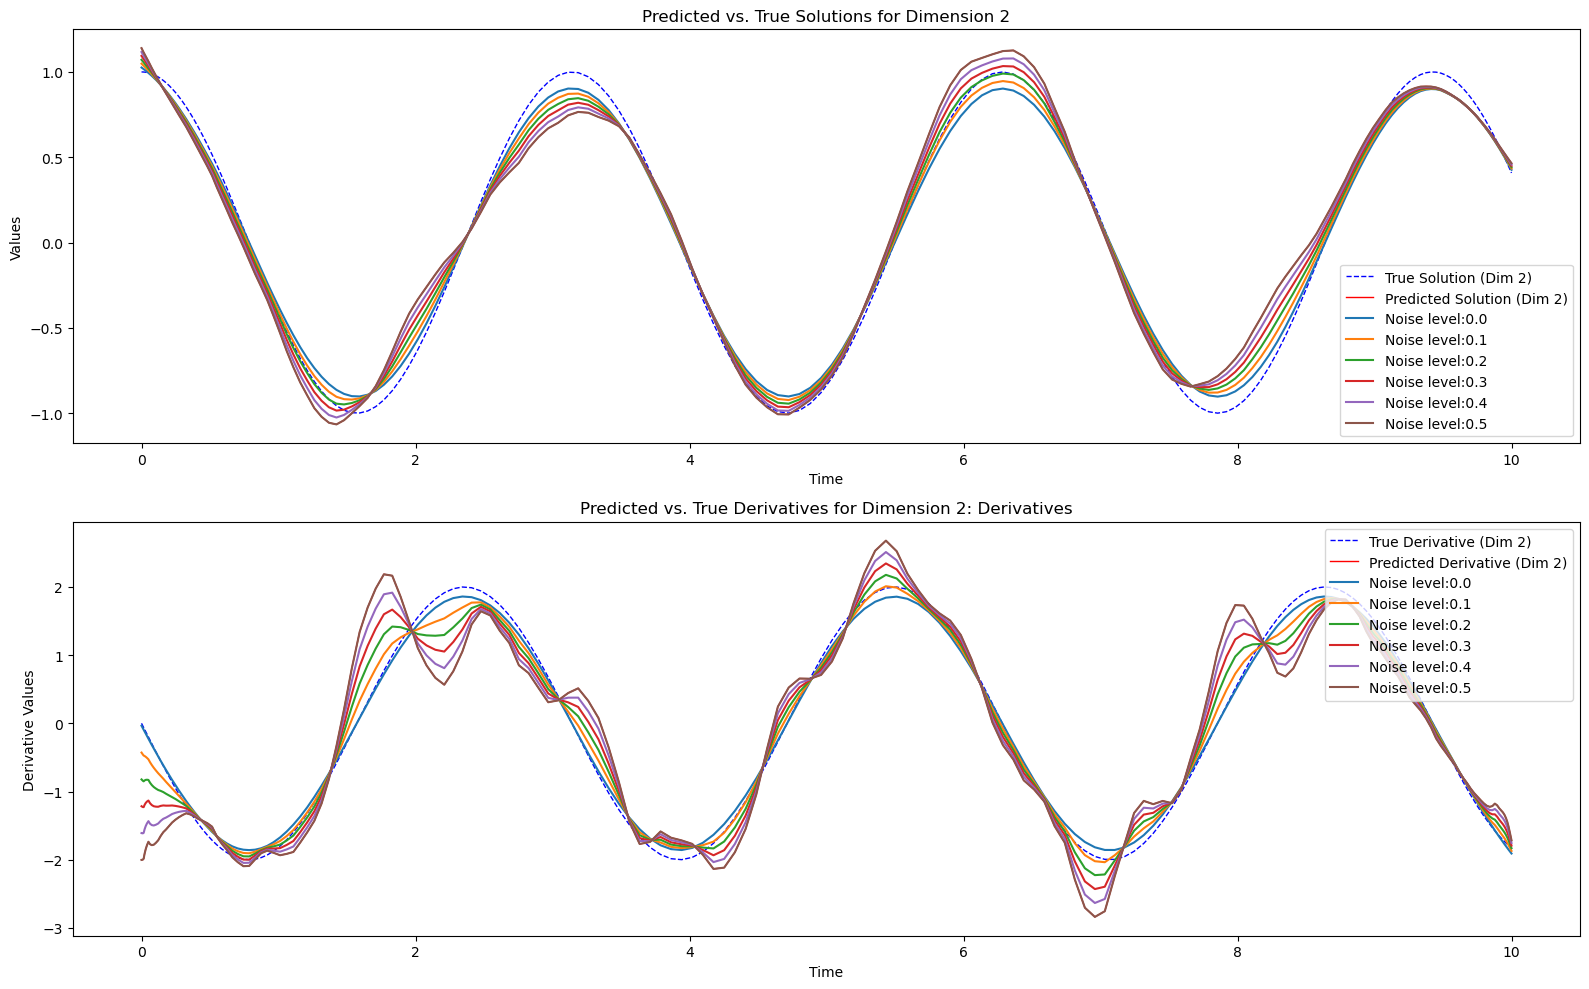

In [11]:
plt.figure(figsize=(16, 10))

# Subplot 1: Solutions
plt.subplot(2, 1, 1)  
plt.plot(t, y[:, 1], 'b--', linewidth=1, label='True Solution (Dim 2)')
plt.plot(t, estimated_solution[1], 'r-', linewidth=1, label='Predicted Solution (Dim 2)')
for i in range(len(results)):
    result = results[str(i)]
    plt.plot(t, result['estimated_solution'][1], label=f"Noise level:{result['noise_level']}")
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Predicted vs. True Solutions for Dimension 2')
plt.legend(loc='lower right')

# Subplot 2: Derivatives
plt.subplot(2, 1, 2)  
plt.plot(t, true_derivatives[:, 1], 'b--', linewidth=1, label='True Derivative (Dim 2)')
plt.plot(t, estimated_derivative[1], 'r-', linewidth=1, label='Predicted Derivative (Dim 2)')
for i in range(len(results)):
    result = results[str(i)]
    plt.plot(t, result['estimated_derivative'][1], label=f"Noise level:{result['noise_level']}")
plt.xlabel('Time')
plt.ylabel('Derivative Values')
plt.title('Predicted vs. True Derivatives for Dimension 2: Derivatives')
plt.legend(loc='upper right')

print(f"Loss equal: {jnp.mean(jnp.abs(true_derivatives.T[1] - estimated_derivative[1])):.3f}")
print(f"Loss Chebyshev: {jnp.mean(jnp.abs(true_derivatives_cheb.T[1] - estimated_derivative_cheb[1])):.3f}")

plt.tight_layout() 
plt.show()


### Chebyshev Nodes

In [8]:
#--------------------------------------------NON PARAMETRIC COLLOCATION--------------------------------------------#
#-----------------------------------------------VARYING NOISE LEVELS-----------------------------------------------#
results_chebyshev = {}
spacing_type ='chebyshev'

for i, noise in enumerate([0.0, 0.1, 0.2, 0.3, 0.4, 0.5]):
    t, y, y_noisy, true_derivatives = generate_ode_data(n_points, noise, ode_type, params, start_time, end_time, spacing_type, initial_state)
    
    estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)
    
    results_chebyshev[str(i)] = {'y_true':y, 'y_noisy': y_noisy, 't':t, 'estimated_derivative':estimated_derivative, 'estimated_solution':estimated_solution, "noise_level":noise}

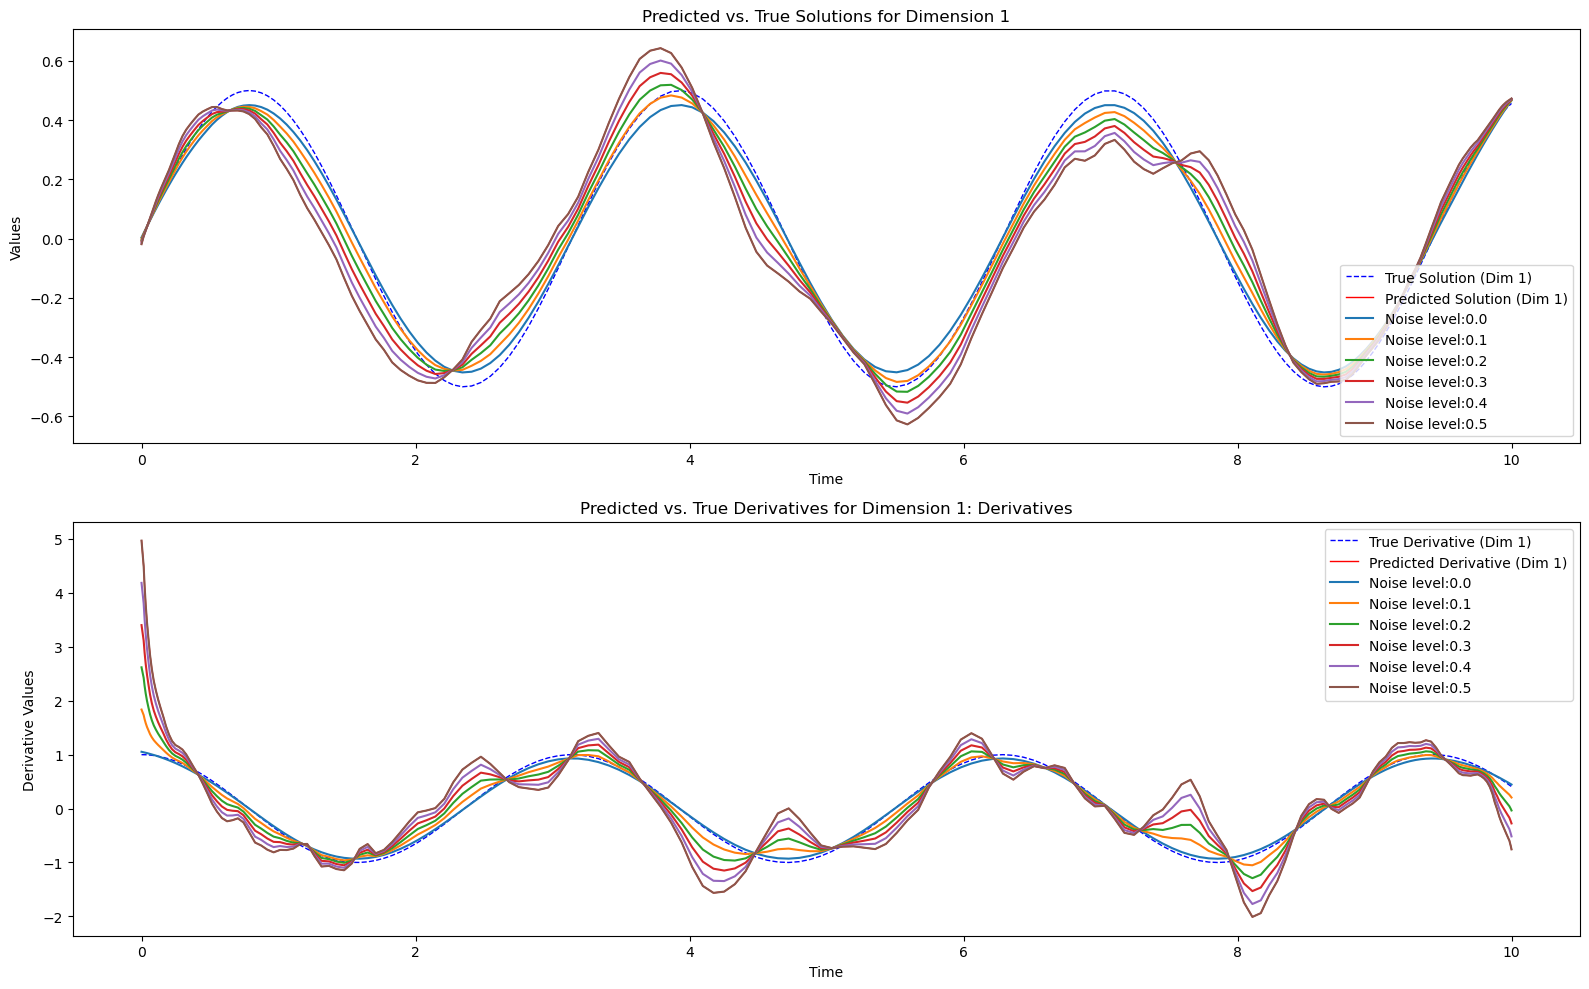

In [9]:
plt.figure(figsize=(16, 10))

# Subplot 1: Solutions
plt.subplot(2, 1, 1)  
plt.plot(t, y[:, 0], 'b--', linewidth=1, label='True Solution (Dim 1)')
plt.plot(t, estimated_solution[0], 'r-', linewidth=1, label='Predicted Solution (Dim 1)')
for i in range(len(results_chebyshev)):
    result = results_chebyshev[str(i)]
    plt.plot(t, result['estimated_solution'][0], label=f"Noise level:{result['noise_level']}")
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Predicted vs. True Solutions for Dimension 1')
plt.legend(loc='lower right')

# Subplot 2: Derivatives
plt.subplot(2, 1, 2)  
plt.plot(t, true_derivatives[:, 0], 'b--', linewidth=1, label='True Derivative (Dim 1)')
plt.plot(t, estimated_derivative[0], 'r-', linewidth=1, label='Predicted Derivative (Dim 1)')
for i in range(len(results_chebyshev)):
    result = results_chebyshev[str(i)]
    plt.plot(t, result['estimated_derivative'][0], label=f"Noise level:{result['noise_level']}")
plt.xlabel('Time')
plt.ylabel('Derivative Values')
plt.title('Predicted vs. True Derivatives for Dimension 1: Derivatives')
plt.legend(loc='upper right')

plt.tight_layout() 
plt.show()
